<a href="https://colab.research.google.com/github/JuanitaCathy/tamil-palm-leaf-manuscript-DL/blob/main/Palm_Leaf_Script_Tamil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
image_path = "/content/img.png"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

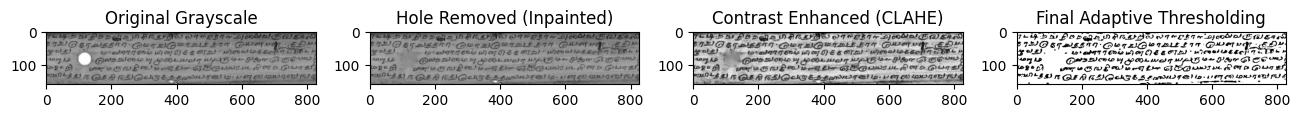

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 1️⃣ --- BACKGROUND NORMALIZATION ---
blurred = cv2.GaussianBlur(gray, (5,5), 0)  # Reduce uneven lighting

# 2️⃣ --- HOLE DETECTION & REMOVAL ---
_, hole_mask = cv2.threshold(blurred, 230, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(hole_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
hole_mask_filled = np.zeros_like(gray)

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if 0.8 < w/h < 1.2 and w > 10:
        cv2.drawContours(hole_mask_filled, [cnt], -1, 255, thickness=-1)
        cv2.drawContours(hole_mask_filled, [cnt], -1, 255, thickness=10)

hole_filled = cv2.inpaint(gray, hole_mask_filled, inpaintRadius=10, flags=cv2.INPAINT_TELEA)

# 3️⃣ --- CONTRAST ENHANCEMENT (CLAHE) ---
clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8,8))
enhanced = clahe.apply(hole_filled)

# 4️⃣ --- DENOISING (MEDIAN FILTER) ---
denoised = cv2.bilateralFilter(enhanced, d=10, sigmaColor=80, sigmaSpace=80)

# 5️⃣ --- ADAPTIVE THRESHOLDING ---
binary_adaptive = cv2.adaptiveThreshold(
    denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 9
)

# 6️⃣ --- DISPLAY RESULTS ---
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
axes[0].imshow(gray, cmap='gray'); axes[0].set_title("Original Grayscale")
axes[1].imshow(hole_filled, cmap='gray'); axes[1].set_title("Hole Removed (Inpainted)")
axes[2].imshow(enhanced, cmap='gray'); axes[2].set_title("Contrast Enhanced (CLAHE)")
axes[3].imshow(binary_adaptive, cmap='gray'); axes[3].set_title("Final Adaptive Thresholding")

plt.show()


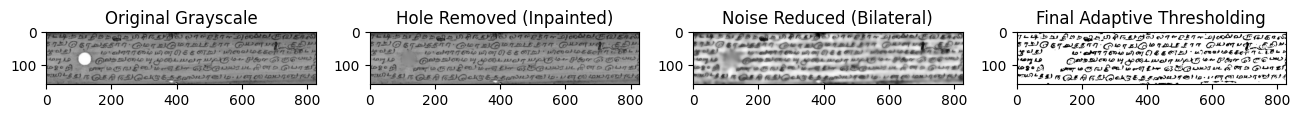

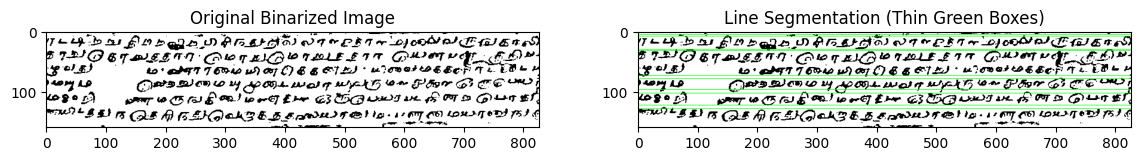

In [ ]:
# 1️⃣ --- Background Normalization ---
blurred = cv2.GaussianBlur(gray, (5,5), 0)  # Reduce uneven lighting

# 2️⃣ --- HOLE DETECTION & REMOVAL ---
_, hole_mask = cv2.threshold(blurred, 230, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(hole_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
hole_mask_filled = np.zeros_like(gray)

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if 0.8 < w/h < 1.2 and w > 10:
        cv2.drawContours(hole_mask_filled, [cnt], -1, 255, thickness=-1)
        cv2.drawContours(hole_mask_filled, [cnt], -1, 255, thickness=10)

hole_filled = cv2.inpaint(gray, hole_mask_filled, inpaintRadius=10, flags=cv2.INPAINT_TELEA)

# 3️⃣ --- Contrast Enhancement (CLAHE) ---
clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8,8))
enhanced = clahe.apply(hole_filled)

# 4️⃣ --- Denoising (Stronger Bilateral Filter) ---
denoised = cv2.bilateralFilter(enhanced, d=12, sigmaColor=90, sigmaSpace=90)

# 5️⃣ --- Morphological Opening (Noise Reduction) ---
kernel = np.ones((2,2), np.uint8)
opened = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel)

# 6️⃣ --- Adaptive Thresholding (Fine-Tuned) ---
binary_adaptive = cv2.adaptiveThreshold(
    opened, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 9
)

# 7️⃣ --- Display Results ---
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
axes[0].imshow(gray, cmap='gray'); axes[0].set_title("Original Grayscale")
axes[1].imshow(hole_filled, cmap='gray'); axes[1].set_title("Hole Removed (Inpainted)")
axes[2].imshow(denoised, cmap='gray'); axes[2].set_title("Noise Reduced (Bilateral)")
axes[3].imshow(binary_adaptive, cmap='gray'); axes[3].set_title("Final Adaptive Thresholding")

plt.show()


# Load the binarized image from preprocessing
binary = binary_adaptive.copy()

# Invert image so text is white and background is black
binary_inv = cv2.bitwise_not(binary)

# Sum pixels along horizontal axis (projection profile)
horizontal_projection = np.sum(binary_inv, axis=1)

# Detect line positions using projection peaks
threshold = np.max(horizontal_projection) * 0.15  # Adjust sensitivity for last line
line_positions = np.where(horizontal_projection > threshold)[0]

# Group continuous regions to define bounding boxes
line_boxes = []
start = None

for i in range(len(line_positions) - 1):
    if start is None:
        start = line_positions[i]
    if line_positions[i + 1] - line_positions[i] > 5:  # Gap between lines
        end = line_positions[i]
        line_boxes.append((start, end))
        start = None

# Ensure last detected line is included
if start is not None:
    line_boxes.append((start, line_positions[-1]))

# Copy original image for visualization
line_box_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

# Draw **thin** green bounding boxes around each detected line
for (y_start, y_end) in line_boxes:
    cv2.rectangle(line_box_img, (0, y_start - 2), (binary.shape[1], y_end + 2), (0, 255, 0), 1)
# 🔹 Display the results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(binary, cmap='gray')
axes[0].set_title("Original Binarized Image")

axes[1].imshow(line_box_img)
axes[1].set_title("Line Segmentation (Thin Green Boxes)")
plt.show()

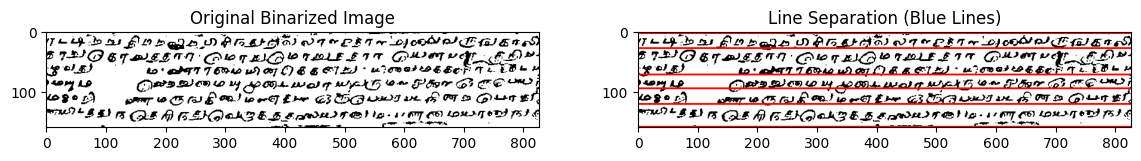

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the binarized image from preprocessing
binary = binary_adaptive.copy()

# Invert image so text is white and background is black
binary_inv = cv2.bitwise_not(binary)

# Sum pixels along horizontal axis (projection profile)
horizontal_projection = np.sum(binary_inv, axis=1)

# Detect line positions using projection peaks
threshold = np.max(horizontal_projection) * 0.15  # Adjust sensitivity for last line
line_positions = np.where(horizontal_projection > threshold)[0]

# Group continuous regions to define line positions
line_separators = []
start = None

for i in range(len(line_positions) - 1):
    if start is None:
        start = line_positions[i]
    if line_positions[i + 1] - line_positions[i] > 5:  # Gap between lines
        end = line_positions[i]
        line_separators.append(end)  # Store only the end for separation
        start = None

# Ensure last detected line is included
if start is not None:
    line_separators.append(line_positions[-1])

# Copy original image for visualization
line_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

# Draw **blue horizontal lines** to separate text lines
for y in line_separators:
    cv2.line(line_img, (0, y), (binary.shape[1], y), (255, 0, 0), 2)  # Blue line

# 🔹 Display the results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(binary, cmap='gray')
axes[0].set_title("Original Binarized Image")

axes[1].imshow(line_img)
axes[1].set_title("Line Separation (Blue Lines)")
plt.show()




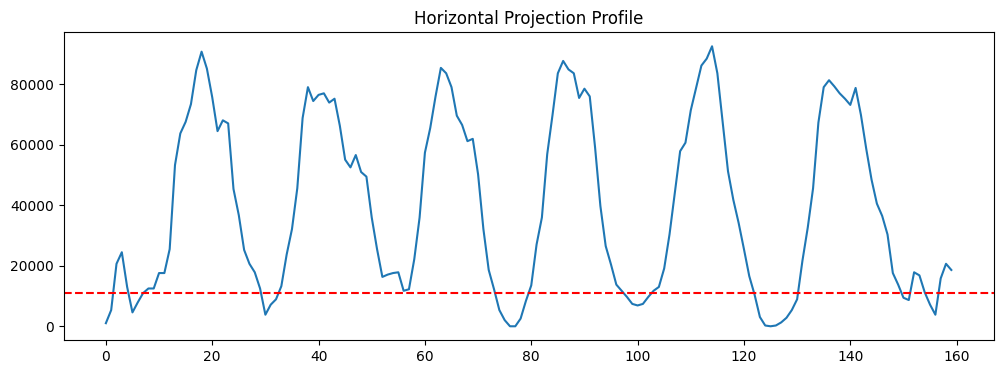

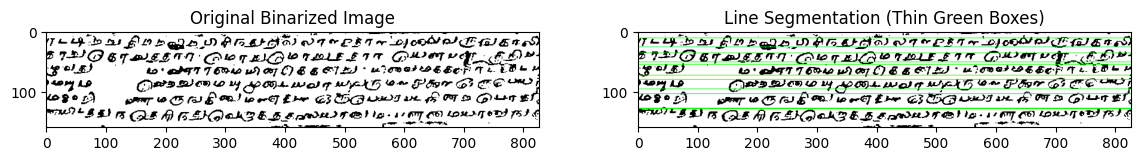

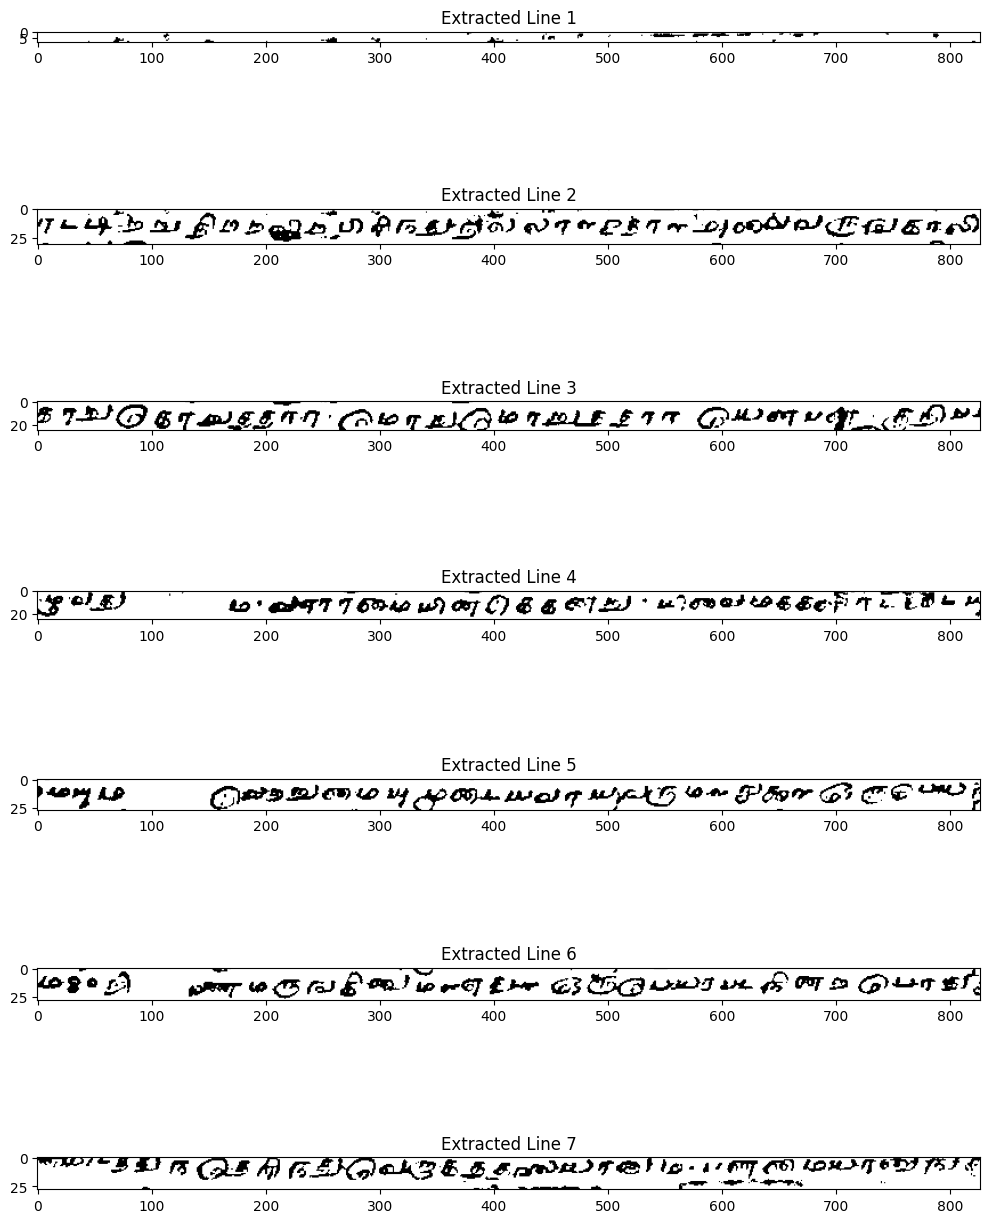

In [ ]:

# Load the binarized image from preprocessing
binary = binary_adaptive.copy()

# Invert image so text is white and background is black
binary_inv = cv2.bitwise_not(binary)

# Sum pixels along the horizontal axis (projection profile)
horizontal_projection = np.sum(binary_inv, axis=1)

# 🔹 Reduce threshold slightly for better sensitivity
threshold = np.max(horizontal_projection) * 0.12

# Detect line positions using projection peaks
line_positions = np.where(horizontal_projection > threshold)[0]

# Group continuous regions to define bounding boxes
line_boxes = []
start = None

for i in range(len(line_positions) - 1):
    if start is None:
        start = line_positions[i]

    # 🔹 Reduced gap threshold from `5` to `3` pixels (prevents merging)
    if line_positions[i + 1] - line_positions[i] > 3:
        end = line_positions[i]

        # Expand box height slightly (padding to prevent text cutting)
        padding = 5
        start = max(0, start - padding)
        end = min(binary.shape[0], end + padding)

        line_boxes.append((start, end))
        start = None

# Ensure the last detected line is included
if start is not None:
    line_boxes.append((start, line_positions[-1]))

# 🔹 Last-line Fix: If the last rows have text, add them explicitly
last_region_intensity = np.sum(binary_inv[-15:, :])  # Check last 15 rows
if last_region_intensity > threshold * 10:
    line_boxes.append((line_positions[-1], binary.shape[0] - 1))

# 🔹 Split Merged Lines (Check for very tall bounding boxes)
average_height = np.mean([end - start for start, end in line_boxes])
new_line_boxes = []
for (y_start, y_end) in line_boxes:
    if (y_end - y_start) > 1.7 * average_height:  # If too tall, split in half
        mid = (y_start + y_end) // 2
        new_line_boxes.append((y_start, mid))
        new_line_boxes.append((mid, y_end))
    else:
        new_line_boxes.append((y_start, y_end))

line_boxes = new_line_boxes  # Update bounding boxes

# Copy original image for visualization
line_box_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

# Extract each line as a separate image
line_images = []
for i, (y_start, y_end) in enumerate(line_boxes):
    # Check if y_start and y_end are the same before cropping
    if y_start != y_end:
        line_img = binary[y_start:y_end, :]  # Crop each line
        line_images.append(line_img)
        cv2.imwrite(f"line_{i+1}.png", line_img)

        # Draw bounding boxes for visualization
        cv2.rectangle(line_box_img, (0, y_start - 2), (binary.shape[1], y_end + 2), (0, 255, 0), 1)  # Thin green box
    else:
        print(f"Warning: Skipping empty line segment at index {i} (y_start = y_end = {y_start})")


# 🔹 Debug Plot: Horizontal Projection
plt.figure(figsize=(12, 4))
plt.plot(horizontal_projection)
plt.axhline(y=threshold, color='r', linestyle='--')
plt.title("Horizontal Projection Profile")
plt.show()

# 🔹 Display Results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(binary, cmap='gray')
axes[0].set_title("Original Binarized Image")

axes[1].imshow(line_box_img)
axes[1].set_title("Line Segmentation (Thin Green Boxes)")
plt.show()

# 🔹 Display Each Extracted Line
fig, axes = plt.subplots(len(line_images), 1, figsize=(10, len(line_images) * 2))
for i, line_img in enumerate(line_images):
    axes[i].imshow(line_img, cmap='gray')
    axes[i].set_title(f"Extracted Line {i+1}")
plt.tight_layout()
plt.show()


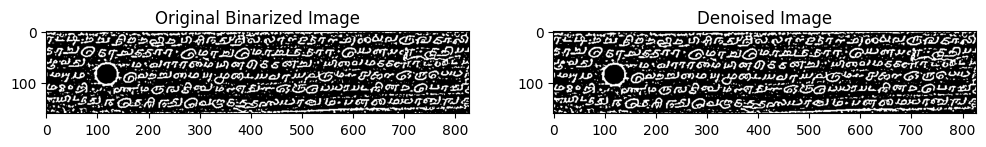

In [ ]:
# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(image, (3, 3), 0)

gray_blurred = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)


# Apply adaptive thresholding for binarization
binary = cv2.adaptiveThreshold(
    gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

# Perform morphological operations to remove small noise
kernel = np.ones((2, 2), np.uint8)
binary_cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

# Show results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(binary, cmap="gray")
axes[0].set_title("Original Binarized Image")
axes[1].imshow(binary_cleaned, cmap="gray")
axes[1].set_title("Denoised Image")
plt.show()

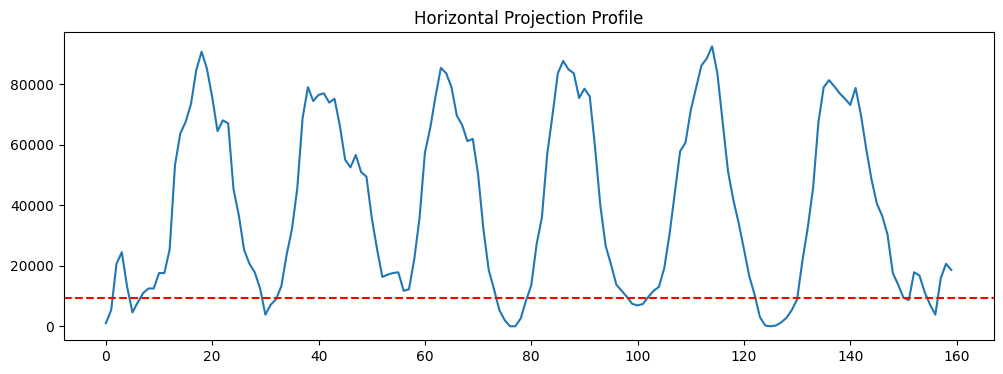

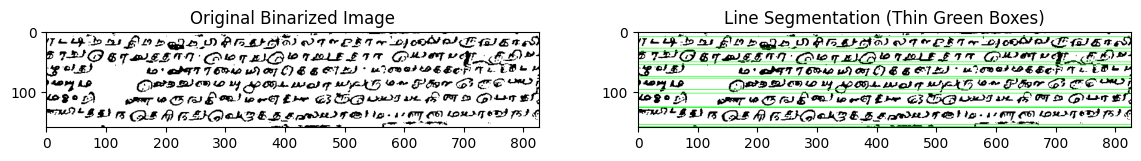

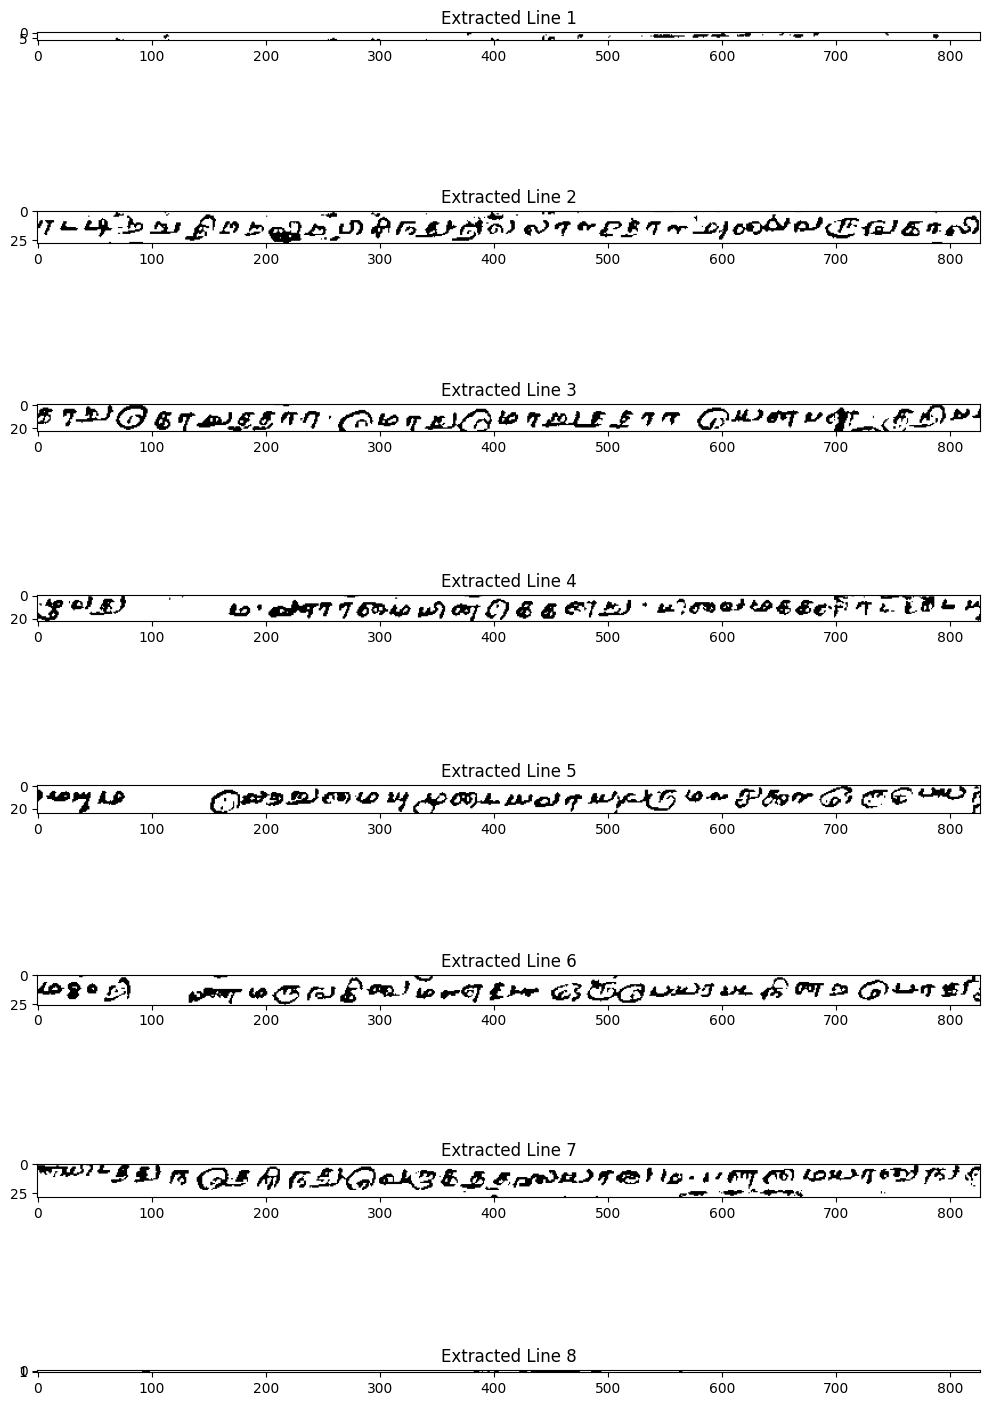

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the binarized image from preprocessing
binary = binary_adaptive.copy()

# Invert image so text is white and background is black
binary_inv = cv2.bitwise_not(binary)

# Sum pixels along the horizontal axis (projection profile)
horizontal_projection = np.sum(binary_inv, axis=1)

# 🔹 Adjust threshold sensitivity to prevent merging
threshold = np.max(horizontal_projection) * 0.10

# Detect line positions using projection peaks
line_positions = np.where(horizontal_projection > threshold)[0]

# Group continuous regions to define bounding boxes
line_boxes = []
start = None

for i in range(len(line_positions) - 1):
    if start is None:
        start = line_positions[i]

    # 🔹 Reduce gap threshold for better separation
    if line_positions[i + 1] - line_positions[i] > 2:  # Smaller gap
        end = line_positions[i]

        # 🔹 Reduce padding to prevent overlap
        padding = 3
        start = max(0, start - padding)
        end = min(binary.shape[0], end + padding)

        line_boxes.append((start, end))
        start = None

# Ensure the last detected line is included
if start is not None:
    line_boxes.append((start, line_positions[-1]))

# 🔹 Last-line Fix: If the last rows have text, add them explicitly
last_region_intensity = np.sum(binary_inv[-10:, :])  # Check last 10 rows
if last_region_intensity > threshold * 10:
    line_boxes.append((line_positions[-1], binary.shape[0] - 1))

# 🔹 Split Merged Lines: If one box is too large, split it
average_height = np.mean([end - start for start, end in line_boxes])
new_line_boxes = []
for (y_start, y_end) in line_boxes:
    if (y_end - y_start) > 1.5 * average_height:  # If too tall, split in half
        mid = (y_start + y_end) // 2
        new_line_boxes.append((y_start, mid))
        new_line_boxes.append((mid, y_end))
    else:
        new_line_boxes.append((y_start, y_end))

line_boxes = new_line_boxes  # Update bounding boxes

# Copy original image for visualization
line_box_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

# Extract each line as a separate image
line_images = []
for i, (y_start, y_end) in enumerate(line_boxes):
    if y_start != y_end:
        line_img = binary[y_start:y_end, :]  # Crop each line
        line_images.append(line_img)
        cv2.imwrite(f"line_{i+1}.png", line_img)

        # Draw bounding boxes for visualization
        cv2.rectangle(line_box_img, (0, y_start - 2), (binary.shape[1], y_end + 2), (0, 255, 0), 1)  # Thin green box
    else:
        print(f"Warning: Skipping empty line segment at index {i} (y_start = y_end = {y_start})")

# 🔹 Debug Plot: Horizontal Projection
plt.figure(figsize=(12, 4))
plt.plot(horizontal_projection)
plt.axhline(y=threshold, color='r', linestyle='--')
plt.title("Horizontal Projection Profile")
plt.show()

# 🔹 Display Results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(binary, cmap='gray')
axes[0].set_title("Original Binarized Image")

axes[1].imshow(line_box_img)
axes[1].set_title("Line Segmentation (Thin Green Boxes)")
plt.show()

# 🔹 Display Each Extracted Line
fig, axes = plt.subplots(len(line_images), 1, figsize=(10, len(line_images) * 2))
for i, line_img in enumerate(line_images):
    axes[i].imshow(line_img, cmap='gray')
    axes[i].set_title(f"Extracted Line {i+1}")
plt.tight_layout()
plt.show()


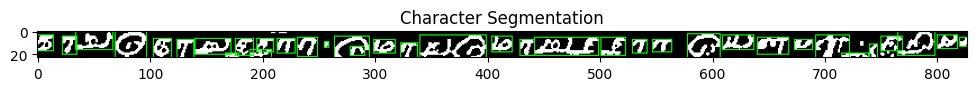

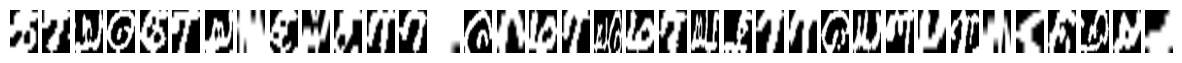

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the extracted line image
line_img = cv2.imread("line_3.png", cv2.IMREAD_GRAYSCALE)

# Preprocessing
blurred = cv2.GaussianBlur(line_img, (5, 5), 0)  # Reduce uneven lighting
clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8, 8))
enhanced = clahe.apply(blurred)  # Contrast enhancement
binary = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 9)

# Find contours (character segmentation)
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])  # Left-to-right sorting

# Copy image for visualization
char_box_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
char_images = []

# Extract characters
for i, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)

    # Ignore small noise
    if w > 3 and h > 3:
        char_img = binary[y:y+h, x:x+w]

        # Resize characters for better visualization
        char_img = cv2.resize(char_img, (50, 80), interpolation=cv2.INTER_LINEAR)

        char_images.append(char_img)
        cv2.imwrite(f"char_{i+1}.png", char_img)

        # Draw bounding box
        cv2.rectangle(char_box_img, (x, y), (x + w, y + h), (0, 255, 0), 1)

# Display character segmentation
plt.figure(figsize=(12, 4))
plt.imshow(char_box_img, cmap='gray')
plt.title("Character Segmentation")
plt.show()

# Show extracted characters
fig, axes = plt.subplots(1, len(char_images), figsize=(15, 5))
for i, char_img in enumerate(char_images):
    axes[i].imshow(char_img, cmap='gray')
    axes[i].axis("off")

plt.show()


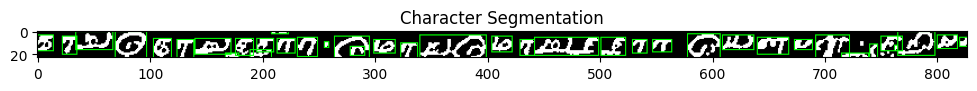

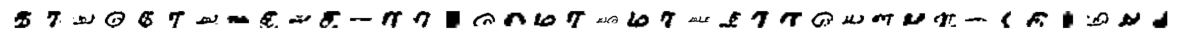

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the extracted line image
line_img = cv2.imread("line_3.png", cv2.IMREAD_GRAYSCALE)

# Preprocessing
blurred = cv2.GaussianBlur(line_img, (5, 5), 0)  # Reduce uneven lighting
clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8, 8))
enhanced = clahe.apply(blurred)  # Contrast enhancement

# Adaptive Thresholding (Black BG, White Text)
binary = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 9)

# Find contours (character segmentation)
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])  # Left-to-right sorting

# Compute average character height
heights = [cv2.boundingRect(cnt)[3] for cnt in contours]
avg_height = np.mean(heights) if heights else 0  # Avoid division by zero

# Filter contours dynamically based on average height
filtered_contours = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)

    # Ignore tiny noise but keep valid small characters
    if h > 0.4 * avg_height or w > 0.4 * avg_height:
        filtered_contours.append(cnt)

# Copy image for visualization
char_box_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
char_images = []

# Set standardized character size (BIG with padding)
target_size = (200, 250)  # Increased size for better clarity
padding = 20  # Fixed padding around characters

for i, cnt in enumerate(filtered_contours):
    x, y, w, h = cv2.boundingRect(cnt)

    char_img = binary[y:y+h, x:x+w]

    # Create a blank BLACK image with padding
    padded_img = np.full(target_size, 0, dtype=np.uint8)  # Black background

    # Scale character while maintaining aspect ratio
    scale = min((target_size[1] - 2 * padding) / w, (target_size[0] - 2 * padding) / h)
    new_w, new_h = int(w * scale), int(h * scale)

    # Resize character
    resized_char = cv2.resize(char_img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Center the resized character in the padded image
    x_offset = (target_size[1] - new_w) // 2
    y_offset = (target_size[0] - new_h) // 2
    padded_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_char

    # Invert colors (White Text on Black Background)
    final_char = cv2.bitwise_not(padded_img)

    # Apply sharpening filter for better clarity
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_img = cv2.filter2D(final_char, -1, sharpen_kernel)

    char_images.append(sharpened_img)
    cv2.imwrite(f"char_{i+1}.png", sharpened_img)

    # Draw bounding box
    cv2.rectangle(char_box_img, (x, y), (x + w, y + h), (0, 255, 0), 1)

# Display character segmentation
plt.figure(figsize=(12, 4))
plt.imshow(char_box_img, cmap='gray')
plt.title("Character Segmentation")
plt.show()

# Show extracted characters
fig, axes = plt.subplots(1, len(char_images), figsize=(15, 5))
for i, char_img in enumerate(char_images):
    axes[i].imshow(char_img, cmap='gray')
    axes[i].axis("off")

plt.show()


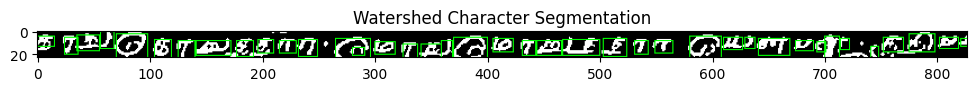

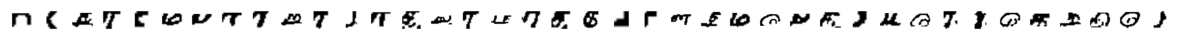

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the grayscale image
line_img = cv2.imread("line_3.png", cv2.IMREAD_GRAYSCALE)

# Preprocessing
blurred = cv2.GaussianBlur(line_img, (3, 3), 0)
clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8, 8))
enhanced = clahe.apply(blurred)

# Adaptive Thresholding
binary = cv2.adaptiveThreshold(
    enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 9
)

# Morphological Thinning (to break thin connections)
kernel = np.ones((2, 2), np.uint8)
thin = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

# Distance Transform
dist_transform = cv2.distanceTransform(thin, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)

# Find Unknown Region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(binary, sure_fg)

# Markers for Watershed
num_labels, markers = cv2.connectedComponents(sure_fg)
markers += 1
markers[unknown == 255] = 0

# Convert image to BGR for visualization
char_box_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

# Apply Watershed
cv2.watershed(char_box_img, markers)

# Find contours again (after watershed)
contours, _ = cv2.findContours(sure_fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

char_images = []
target_size = (300, 350)  # Increased size for better clarity
padding = 30  # Padding around characters

for i, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 5 and h > 5:  # Ignore small noise
        char_img = binary[y:y+h, x:x+w]

        # Create a blank BLACK image with padding
        padded_img = np.full(target_size, 0, dtype=np.uint8)

        # Scale while maintaining aspect ratio
        scale = min((target_size[1] - 2 * padding) / w, (target_size[0] - 2 * padding) / h)
        new_w, new_h = int(w * scale), int(h * scale)

        # Resize character
        resized_char = cv2.resize(char_img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        # Center the resized character in the padded image
        x_offset = (target_size[1] - new_w) // 2
        y_offset = (target_size[0] - new_h) // 2
        padded_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_char

        # Invert colors (White Text on Black Background)
        final_char = cv2.bitwise_not(padded_img)

        # Apply sharpening filter for better clarity
        sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        sharpened_img = cv2.filter2D(final_char, -1, sharpen_kernel)

        char_images.append(sharpened_img)
        cv2.imwrite(f"char_{i+1}.png", sharpened_img)

        # Draw bounding box
        cv2.rectangle(char_box_img, (x, y), (x + w, y + h), (0, 255, 0), 1)

# Display character segmentation
plt.figure(figsize=(12, 4))
plt.imshow(char_box_img, cmap='gray')
plt.title("Watershed Character Segmentation")
plt.show()

# Show extracted characters
fig, axes = plt.subplots(1, len(char_images), figsize=(15, 5))
for i, char_img in enumerate(char_images):
    axes[i].imshow(char_img, cmap='gray')
    axes[i].axis("off")

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using device: cuda
✅ Loaded 19864 images from 156 classes.
✅ Loaded 870 images from 156 classes.


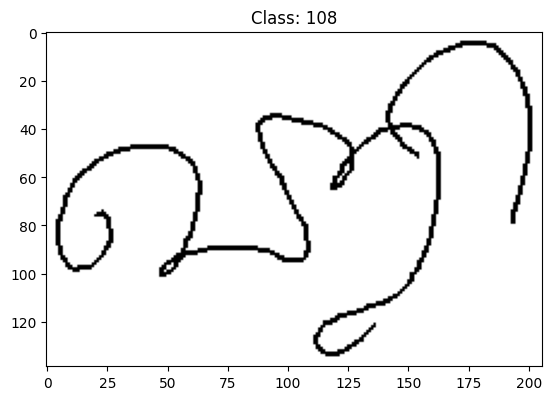

Train samples: 19864
Test samples: 870


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import os
import imageio.v2 as imageio
import random
import matplotlib.pyplot as plt

# 🔹 Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 🔹 Transformations (Ensure 3 Channels for ResNet)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),  # Convert 1 channel to 3 channels
    transforms.Resize((64, 64)),  # Resize for ResNet
    transforms.ToTensor(),
])

# 🔹 Tamil Dataset Class
class TamilDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.transform = transform
        self.data = []

        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            if not os.listdir(class_path):  # Skip empty folders
                continue
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.data.append((img_path, class_idx))

        print(f"✅ Loaded {len(self.data)} images from {len(self.classes)} classes.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      img_path, label = self.data[idx]
      image = imageio.imread(img_path)

      # 🔹 Convert boolean arrays to uint8 (0-255 range)
      if image.dtype == bool:
          image = image.astype(np.uint8) * 255

      if self.transform:
          image = self.transform(image)

      return image, label


# 🔹 Load Dataset (Update Paths)
train_root = "/content/drive/MyDrive/train"
test_root = "/content/drive/MyDrive/test"

train_dataset = TamilDataset(train_root, transform)
test_dataset = TamilDataset(test_root, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 🔹 Visualize Sample
random_sample = random.choice(train_dataset.data)
img_path, label = random_sample
img = imageio.imread(img_path)

plt.imshow(img, cmap="gray")
plt.title(f"Class: {label}")
plt.show()

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


In [ ]:
# 🔹 Load Pretrained ResNet-50
num_classes = len(train_dataset.classes)  # Number of Tamil character classes
model = models.resnet50(pretrained=True)

# Modify final fully connected layer to match our class count
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU if available
model = model.to(device)

print(model)  # Check model architecture


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 🔹 Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 🔹 Learning Rate Scheduler (Decays LR every 5 epochs)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [ ]:
from tqdm import tqdm  # Progress bar

# 🔹 Training Parameters
num_epochs = 15
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 🔹 Validate Model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total if total > 0 else 0  # Avoid division by zero
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.4f}")

    # 🔹 Save Best Model
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save(model.state_dict(), "best_tamil_model.pth")
        print("✅ Best model saved!")

    scheduler.step()  # Update learning rate


100%|██████████| 621/621 [3:15:50<00:00, 18.92s/it]


Epoch 1/15, Loss: 514.9576, Accuracy: 0.8943
✅ Best model saved!


100%|██████████| 621/621 [02:17<00:00,  4.52it/s]


Epoch 2/15, Loss: 177.9386, Accuracy: 0.9161
✅ Best model saved!


100%|██████████| 621/621 [02:18<00:00,  4.49it/s]


Epoch 3/15, Loss: 129.1274, Accuracy: 0.9379
✅ Best model saved!


100%|██████████| 621/621 [02:17<00:00,  4.51it/s]


Epoch 4/15, Loss: 100.1322, Accuracy: 0.9011


100%|██████████| 621/621 [02:18<00:00,  4.49it/s]


Epoch 5/15, Loss: 75.8509, Accuracy: 0.9529
✅ Best model saved!


 18%|█▊        | 114/621 [00:25<01:54,  4.43it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import os
from PIL import Image
import numpy as np

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
model = models.resnet50(pretrained=False)
num_classes = len(os.listdir('/content/drive/MyDrive/train'))  # Adjust based on dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Load weights
model.load_state_dict(torch.load("best_tamil_model.pth", map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-17-240e3d9b7432>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Define preprocessing (should match the training phase)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert OpenCV NumPy image to PIL
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.Resize((64, 64)),  # Match training image size
    transforms.ToTensor(),
])

# Class labels mapping (ensure sorted order matches training)
class_folders = sorted(os.listdir('/content/drive/MyDrive/train'))
class_to_char = {i: class_folders[i] for i in range(len(class_folders))}

predictions = []

for i, char_img in enumerate(char_images):
    # Convert OpenCV (NumPy) image to Tensor
    char_tensor = transform(char_img).unsqueeze(0).to(device)  # Add batch dimension

    # Predict character
    with torch.no_grad():
        output = model(char_tensor)
        _, predicted_class = torch.max(output, 1)

    tamil_character = class_to_char[predicted_class.item()]
    predictions.append(tamil_character)

    print(f"Character {i+1}: {tamil_character}")


Character 1: 82
Character 2: 62
Character 3: 57
Character 4: 57
Character 5: 57
Character 6: 63
Character 7: 57
Character 8: 82
Character 9: 82
Character 10: 63
Character 11: 82
Character 12: 83
Character 13: 65
Character 14: 63
Character 15: 63
Character 16: 82
Character 17: 62
Character 18: 82
Character 19: 63
Character 20: 63
Character 21: 52
Character 22: 46
Character 23: 86
Character 24: 52
Character 25: 57
Character 26: 92
Character 27: 63
Character 28: 99
Character 29: 83
Character 30: 57
Character 31: 65
Character 32: 82
Character 33: 83
Character 34: 99
Character 35: 63
Character 36: 82
Character 37: 65
Character 38: 57
Character 39: 83


In [ ]:
import pandas as pd

# Load Tamil character mapping CSV
df = pd.read_csv("/content/TamilChar.csv", encoding="utf-8")
# Ensure CSV has 'class' and 'unicode' columns
print(df.columns)

# Create dictionary: {class_label -> Unicode character}
unicode_mapping = {row['Class Id']: row['Unicode'] for _, row in df.iterrows()}



Index(['Class Id', 'Tamil Character', 'Unicode'], dtype='object')


In [ ]:
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces
unicode_mapping = {row['Class Id']: row['Unicode'] for _, row in df.iterrows()}


In [ ]:
print(chr(0x0B85))


அ


In [ ]:
predicted_unicode_chars = []

for i, char_img in enumerate(char_images):
    char_tensor = transform(char_img).unsqueeze(0).to(device)  # Preprocess image

    with torch.no_grad():
        output = model(char_tensor)
        _, predicted_class = torch.max(output, 1)

    tamil_class = class_to_char[predicted_class.item()]
    tamil_unicode = unicode_mapping.get(tamil_class, "?")  # Get Unicode, else "?"

    predicted_unicode_chars.append(tamil_unicode)
    print(f"Character {i+1}: {tamil_unicode} ({tamil_class})")

# Join recognized characters to form text
recognized_text = "".join(predicted_unicode_chars)
print("\n🔹 Recognized Tamil Text: ", recognized_text)


Character 1: ? (82)
Character 2: ? (62)
Character 3: ? (57)
Character 4: ? (57)
Character 5: ? (57)
Character 6: ? (63)
Character 7: ? (57)
Character 8: ? (82)
Character 9: ? (82)
Character 10: ? (63)
Character 11: ? (82)
Character 12: ? (83)
Character 13: ? (65)
Character 14: ? (63)
Character 15: ? (63)
Character 16: ? (82)
Character 17: ? (62)
Character 18: ? (82)
Character 19: ? (63)
Character 20: ? (63)
Character 21: ? (52)
Character 22: ? (46)
Character 23: ? (86)
Character 24: ? (52)
Character 25: ? (57)
Character 26: ? (92)
Character 27: ? (63)
Character 28: ? (99)
Character 29: ? (83)
Character 30: ? (57)
Character 31: ? (65)
Character 32: ? (82)
Character 33: ? (83)
Character 34: ? (99)
Character 35: ? (63)
Character 36: ? (82)
Character 37: ? (65)
Character 38: ? (57)
Character 39: ? (83)

🔹 Recognized Tamil Text:  ???????????????????????????????????????
